Here we have a 3D themoelasticity problem with 3 different themal properties at different parts of the domain. The overall domain is $\Omega = [0,5e-3] \times [0,5e-3] \times [-5e-4,5e-4]$ with the subdomains

$\Omega_1 = [0,5e-3] \times [0,5e-3] \times [0,5e-4]$

$\Omega_2 = [0,2.5e-3] \times [0,5e-3] \times [-5e-4,0]$

$\Omega_3 = [2.5e-3,5e-3] \times [0,5e-3] \times [-5e-4,0]$

The thermal conductivity and expansion coefficients are

$k = k_i ∀ x \in Ω_i$ where $i = $1, 2, 3

$\alpha = \alpha_i ∀ x \in Ω_i$ where $i = $1, 2, 3

In [269]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [270]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-development-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [271]:
!apt-get install gmsh
!pip install --upgrade gmsh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gmsh is already the newest version (4.8.4+ds2-2build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [272]:
import gmsh

In [273]:
# Give path to save the mesh file
meshPath = '/content/drive/MyDrive/'

def CP3mesh(Hmax, elementType, elementOrder):
  gmsh.initialize()
  gmsh.model.add('cp3mesh')
  meshObject = gmsh.model

  point1 = meshObject.geo.addPoint(0,0,-5e-4,Hmax,1)
  point2 = meshObject.geo.addPoint(5e-3,0,-5e-4,Hmax,2)
  point3 = meshObject.geo.addPoint(5e-3,5e-3,-5e-4,Hmax,3)
  point4 = meshObject.geo.addPoint(0,5e-3,-5e-4,Hmax,4)

  line1 = meshObject.geo.addLine(point1, point2, 101)
  line2 = meshObject.geo.addLine(point2, point3, 102)
  line3 = meshObject.geo.addLine(point3, point4, 103)
  line4 = meshObject.geo.addLine(point4, point1, 104)

  boundary = meshObject.geo.addCurveLoop([line1, line2, line3, line4], 201)

  domain2D = meshObject.geo.addPlaneSurface([boundary], 301)

  domain3D = meshObject.geo.extrude([(2, domain2D)], 0, 0, 1e-3)

  domain3D[0], domain3D[1] = domain3D[1], domain3D[0]

  meshObject.geo.synchronize()

  meshObject.geo.synchronize()

  meshObject.addPhysicalGroup(3, [domain3D[0][1]], name='domain')
  meshObject.addPhysicalGroup(2, [301], 1)

  for i in range(1,len(domain3D)):
    meshObject.addPhysicalGroup(2, [domain3D[i][1]], i+1)

  meshObject.mesh.setOrder(elementOrder)

  if elementType == 2:
    # Generate quad mesh from triangles by recombination
    meshObject.mesh.setRecombine(2, domain2D)

  # Generate the mesh
  gmsh.model.mesh.generate(3)

  gmsh.write(meshPath + 'cp3ChipMeshFile3D.msh')

  gmsh.finalize()

  return

In [274]:
# Generate the mesh
elementOrder = 1 # Polynomial order in each element (integer)
elementType = 1 # 1 - Tetrahedra; 2 - Hexes
HMax = 2e-4

CP3mesh(HMax, elementOrder, elementType)

In [275]:
from matplotlib import pyplot as plt
from firedrake.pyplot import tripcolor, tricontour, trisurf, triplot, tricontourf
%matplotlib inline

In [276]:
from google.colab import output
output.enable_custom_widget_manager()

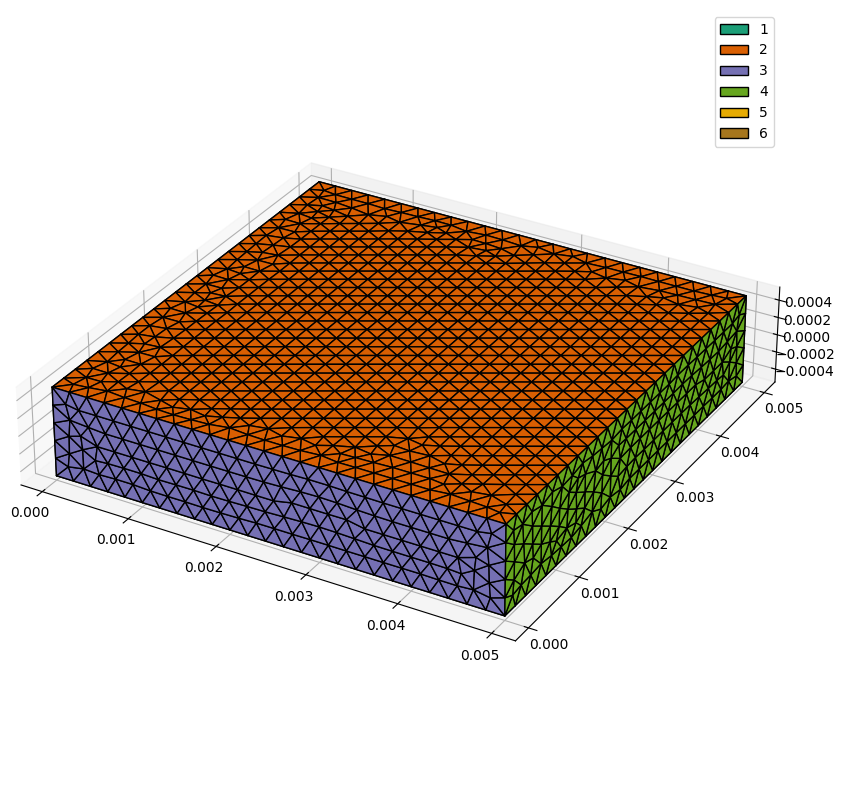

In [277]:
mesh = Mesh(meshPath + 'cp3ChipMeshFile3D.msh')

axes = plt.figure(figsize=[12.8,10]).add_subplot(projection='3d')
triplot(mesh, axes=axes)
axes.legend()
axes.set_aspect('equal')

In [278]:
# Choose function space for temperature
VT = FunctionSpace(mesh, "CG", elementOrder)

In [279]:
# Test and trial function for temperature
T_test = TestFunction(VT)
T_trial = TrialFunction(VT)

Similar to the 2D problem use interpolate function in Firedrake with conditional operator.

Hint : For multiple conditions you can try a nested conditional operator

In [280]:
# Material properties
#--------------Complete the following lines of code----------------------
k_1 = 148
k_2 = 10
k_3 = 80
alpha_1 = 2.6e-6
alpha_2 = 95e-6
alpha_3 = 10e-6
lambda_1 = 256e9
lambda_2 = 12e9
lambda_3 = 80e9
mu_1 = 64e9
mu_2 = 1e9
mu_3 = 31e9

x = SpatialCoordinate(mesh)
x1, x2, x3 = x[0], x[1], x[2]

k_val = conditional(x2 > 0, k_1, conditional(x3 < 0, k_2, k_3))
k = Function(VT)
k.interpolate(k_val)

alpha_val = conditional(x2 > 0, alpha_1, conditional(x3 < 0, alpha_2, alpha_3))
alpha = Function(VT)
alpha.interpolate(alpha_val)

lambda_val = conditional(x2 > 0, lambda_1, conditional(x3 < 0, lambda_2, lambda_3))
llambda = Function(VT)
llambda.interpolate(lambda_val)

mu_val = conditional(x2 > 0, mu_1, conditional(x3 < 0, mu_2, mu_3))
mu = Function(VT)
mu.interpolate(mu_val)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7b0d5efd22d0>, FiniteElement('Lagrange', tetrahedron, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 478)), 984)

In [281]:
# Boundary parameters for temperature
#--------------Complete the following lines of code----------------------
qT = 50e3 + 20e6 * x1
T0 = 293.0

In [282]:
#--------------Complete the following lines of code----------------------
# Variational equation for temperature
aT = k * dot(grad(T_trial), grad(T_test)) * dx
LT = qT * T_test * ds(2)

In [283]:
#--------------Complete the following lines of code----------------------
# Dirichilet boundary condition at z = -5e-4
bcT = DirichletBC(VT, T0, 1)

In [284]:
# Create a function to store the solution
T_soln = Function(VT)

In [285]:
# Solve for temperature
solve(aT == LT, T_soln, bcs = bcT, solver_parameters={'ksp_type': 'gmres'})

In [286]:
#--------------Complete the following lines of code----------------------
# Identity matrix
Id = Identity(mesh.geometric_dimension())

# strain and stress functions
def epsilon(u, Temp, alpha):
  return 0.5 * (grad(u) + grad(u).T) - alpha * Id * (Temp - T0)

def sigma(u, Temp, alpha):
  return llambda * tr(epsilon(u, Temp, alpha)) * Id + 2 * mu * epsilon(u, Temp, alpha)

In [287]:
# Vector function space for displacement
V = VectorFunctionSpace(mesh, "CG", 1)

In [288]:
u = TrialFunction(V)
v = TestFunction(V)

In [289]:
#--------------Complete the following lines of code----------------------
# Variational equation for elasticity
a = lhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx)
L = rhs(inner(sigma(u, T_soln, alpha), grad(v)) * dx)

In [290]:
#--------------Complete the following lines of code----------------------
# Dirichilet BC
bcu = DirichletBC(V, Constant((0.0, 0.0, 0.0)), 6)

In [291]:
# Create a function to store the solution
u_soln = Function(V)

In [292]:
# Solve for displacement
solve(a==L, u_soln, bcs = bcu)

In [293]:
# Vector function space for stress
Vsigma = TensorFunctionSpace(mesh, "DG", 0)

In [294]:
# Project the stress calculation into the tensor space
sigma_soln = project(sigma(u_soln, T_soln, alpha), Vsigma)

In [295]:
from firedrake.output import VTKFile

In [296]:
# Save data as VTK files
path = '/content/drive/MyDrive/'
outfile = VTKFile(path+"CP-3-3.pvd")
outfile.write(T_soln, u_soln, sigma_soln, k, alpha, llambda, mu)

In [297]:
# Deformed mesh
displaced_coordinates = interpolate(SpatialCoordinate(mesh) + 10000* u_soln, V)
mesh.coordinates.assign(displaced_coordinates)

/usr/local/lib/python3.11/dist-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7b0d5efd22d0>, VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), name=None), Mesh(VectorElement(FiniteElement('Lagrange', tetrahedron, 1), dim=3), 478)), 970)

Text(0.5, 0, 'Z')

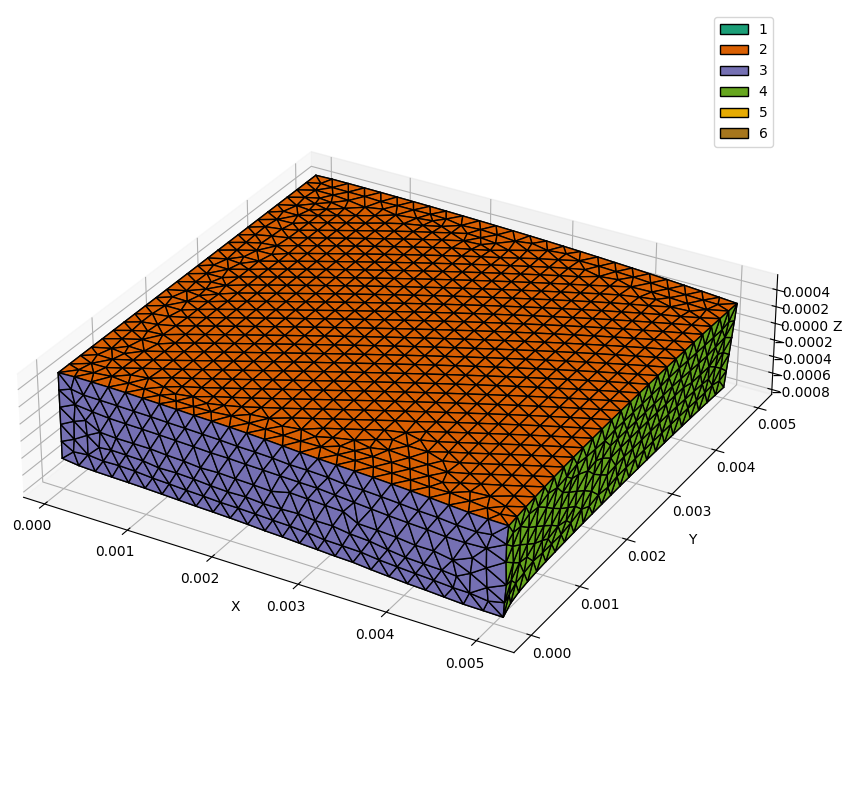

In [298]:
axes = plt.figure(figsize=[12.8,10]).add_subplot(projection='3d')
triplot(mesh, axes=axes)
axes.legend()
axes.set_aspect('equal')
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_zlabel('Z')

Support for third party widgets will remain active for the duration of the session. To disable support:

In [299]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [300]:
from google.colab import output
output.disable_custom_widget_manager()

In [301]:
# Find maximum displacement magnitude
max_displacement = u_magnitude.vector().max()
print(f"Maximum displacement magnitude: {max_displacement:.6e}")

# Find maximum temperature
max_temperature = T_soln.vector().max()
print(f"Maximum temperature: {max_temperature:.6e}")

# Method 1: Use vertices directly if functions are defined on vertices
try:
    # Get function indices for maximum values
    max_disp_idx = u_magnitude.vector().get_local().argmax()
    max_temp_idx = T_soln.vector().get_local().argmax()

    # Get coordinates directly from the mesh
    mesh_coords = mesh.coordinates.vector().get_local().reshape(-1, 3)

    # If the function space has the same DOF ordering as the mesh vertices
    if len(mesh_coords) == len(u_magnitude.vector().get_local()):
        max_disp_coords = mesh_coords[max_disp_idx]
        print(f"Location of maximum displacement: ({max_disp_coords[0]:.4f}, {max_disp_coords[1]:.4f}, {max_disp_coords[2]:.4f})")

    if len(mesh_coords) == len(T_soln.vector().get_local()):
        max_temp_coords = mesh_coords[max_temp_idx]
        print(f"Location of maximum temperature: ({max_temp_coords[0]:.4f}, {max_temp_coords[1]:.4f}, {max_temp_coords[2]:.4f})")
except Exception as e:
    print(f"Method 1 failed: {e}")

# Method 2: Sample the function at mesh vertices
try:
    import numpy as np

    # Get mesh vertices
    mesh_coords = mesh.coordinates.vector().get_local().reshape(-1, 3)

    # Evaluate function at all vertices
    disp_values = np.zeros(len(mesh_coords))
    temp_values = np.zeros(len(mesh_coords))

    for i, point in enumerate(mesh_coords):
        try:
            # Check if the function can be evaluated at this point
            disp_values[i] = u_magnitude.at(point)
            temp_values[i] = T_soln.at(point)
        except Exception:
            # Point might be outside domain
            disp_values[i] = 0
            temp_values[i] = 0

    # Find coordinates with maximum values
    max_disp_vertex_idx = disp_values.argmax()
    max_temp_vertex_idx = temp_values.argmax()

    max_disp_coords = mesh_coords[max_disp_vertex_idx]
    max_temp_coords = mesh_coords[max_temp_vertex_idx]

    print(f"Method 2 - Location of maximum displacement: ({max_disp_coords[0]:.4f}, {max_disp_coords[1]:.4f}, {max_disp_coords[2]:.4f})")
    print(f"Method 2 - Location of maximum temperature: ({max_temp_coords[0]:.4f}, {max_temp_coords[1]:.4f}, {max_temp_coords[2]:.4f})")
except Exception as e:
    print(f"Method 2 failed: {e}")

# Method 3: Sample on a grid covering the domain
try:
    import numpy as np

    # Determine domain bounds
    mesh_coords = mesh.coordinates.vector().get_local().reshape(-1, 3)
    x_min, y_min, z_min = mesh_coords.min(axis=0)
    x_max, y_max, z_max = mesh_coords.max(axis=0)

    # Create a coarse sampling grid
    nx, ny, nz = 20, 20, 20  # Adjust based on domain size
    x_vals = np.linspace(x_min, x_max, nx)
    y_vals = np.linspace(y_min, y_max, ny)
    z_vals = np.linspace(z_min, z_max, nz)

    # Sample at grid points
    max_disp_val = 0
    max_temp_val = 0
    max_disp_loc = None
    max_temp_loc = None

    for x in x_vals:
        for y in y_vals:
            for z in z_vals:
                point = (x, y, z)
                try:
                    disp_val = u_magnitude.at(point)
                    temp_val = T_soln.at(point)

                    if disp_val > max_disp_val:
                        max_disp_val = disp_val
                        max_disp_loc = point

                    if temp_val > max_temp_val:
                        max_temp_val = temp_val
                        max_temp_loc = point
                except Exception:
                    # Point might be outside domain
                    pass

    if max_disp_loc is not None:
        print(f"Method 3 - Approximate location of maximum displacement: ({max_disp_loc[0]:.4f}, {max_disp_loc[1]:.4f}, {max_disp_loc[2]:.4f}), value: {max_disp_val:.6e}")

    if max_temp_loc is not None:
        print(f"Method 3 - Approximate location of maximum temperature: ({max_temp_loc[0]:.4f}, {max_temp_loc[1]:.4f}, {max_temp_loc[2]:.4f}), value: {max_temp_val:.6e}")
except Exception as e:
    print(f"Method 3 failed: {e}")

# Method 4: Use the coordinate function directly if available
try:
    # Try to access mesh coordinates directly through the function space
    coords_func = mesh.coordinates
    print(f"DOF {max_disp_idx} corresponds to node with coordinate index {max_disp_idx % (coords_func.vector().size() // 3)}")

    # Extract the coordinates
    coord_idx = max_disp_idx % (coords_func.vector().size() // 3)
    max_disp_coords = [
        coords_func.vector()[coord_idx * 3],
        coords_func.vector()[coord_idx * 3 + 1],
        coords_func.vector()[coord_idx * 3 + 2]
    ]

    print(f"Method 4 - Location of maximum displacement: ({max_disp_coords[0]:.4f}, {max_disp_coords[1]:.4f}, {max_disp_coords[2]:.4f})")
except Exception as e:
    print(f"Method 4 failed: {e}")

# Fallback summary
print(f"\nSummary of Results:")
print(f"Maximum displacement: {max_displacement:.6e} (at DOF {max_disp_idx})")
print(f"Maximum temperature: {max_temperature:.6e} (at DOF {max_temp_idx})")

# If you have multiple mesh refinements, report this result and keep track
print(f"\nFor mesh refinement level [CURRENT LEVEL], the maximum values are:")
print(f"Maximum displacement magnitude: {max_displacement:.6e}")
print(f"Maximum temperature: {max_temperature:.6e}")

Maximum displacement magnitude: 3.529405e-08
Maximum temperature: 2.940756e+02
Location of maximum displacement: (0.0051, 0.0000, -0.0006)
Location of maximum temperature: (0.0052, -0.0000, 0.0003)
Method 2 - Location of maximum displacement: (0.0000, 0.0000, -0.0005)
Method 2 - Location of maximum temperature: (0.0039, 0.0007, 0.0004)
Method 3 - Approximate location of maximum displacement: (0.0000, -0.0001, -0.0005), value: 2.788885e-08
Method 3 - Approximate location of maximum temperature: (0.0038, 0.0021, 0.0005), value: 2.939151e+02
DOF 764 corresponds to node with coordinate index 764
Method 4 failed: unsupported format string passed to numpy.ndarray.__format__

Summary of Results:
Maximum displacement: 3.529405e-08 (at DOF 764)
Maximum temperature: 2.940756e+02 (at DOF 699)

For mesh refinement level [CURRENT LEVEL], the maximum values are:
Maximum displacement magnitude: 3.529405e-08
Maximum temperature: 2.940756e+02


In [302]:
# Find maximum displacement magnitude
max_displacement = u_magnitude.vector().max()
print(f"Maximum displacement magnitude: {max_displacement:.6e}")

# Find maximum temperature
max_temperature = T_soln.vector().max()
print(f"Maximum temperature: {max_temperature:.6e}")

# Get the indices of maximum values
max_disp_idx = u_magnitude.vector().get_local().argmax()
max_temp_idx = T_soln.vector().get_local().argmax()

# Method to find location of maxima by evaluating function at mesh vertices
import numpy as np

# Get mesh vertices coordinates
mesh_vertices = mesh.coordinates.vector().get_local().reshape(-1, 3)

# Initialize arrays to store function values at vertices
disp_at_vertices = np.zeros(len(mesh_vertices))
temp_at_vertices = np.zeros(len(mesh_vertices))

# Evaluate functions at all mesh vertices
for i, vertex in enumerate(mesh_vertices):
    try:
        # Try to evaluate the functions at each vertex
        disp_at_vertices[i] = u_magnitude.at(vertex)
        temp_at_vertices[i] = T_soln.at(vertex)
    except Exception:
        # Skip points where evaluation fails (might be outside domain)
        pass

# Find vertices with maximum values
max_disp_vertex_idx = np.argmax(disp_at_vertices)
max_temp_vertex_idx = np.argmax(temp_at_vertices)

# Get coordinates of maximum points
max_disp_location = mesh_vertices[max_disp_vertex_idx]
max_temp_location = mesh_vertices[max_temp_vertex_idx]

# Print results with .6e format for all floating point values
print(f"Maximum displacement: {max_displacement:.6e} at location ({max_disp_location[0]:.6e}, {max_disp_location[1]:.6e}, {max_disp_location[2]:.6e})")
print(f"Maximum temperature: {max_temperature:.6e} at location ({max_temp_location[0]:.6e}, {max_temp_location[1]:.6e}, {max_temp_location[2]:.6e})")

# Alternative: Find more precise location using higher resolution sampling near the maximum
# This is useful for more accurate localization

# Get approximate location from initial sampling
approx_max_disp_loc = max_disp_location
approx_max_temp_loc = max_temp_location

# Define a small region around the approximate maximum points for refined search
search_radius = 0.1  # Adjust based on your mesh size

# Create refined sampling grid around displacement maximum
x_min_disp = max(approx_max_disp_loc[0] - search_radius, mesh_vertices[:, 0].min())
x_max_disp = min(approx_max_disp_loc[0] + search_radius, mesh_vertices[:, 0].max())
y_min_disp = max(approx_max_disp_loc[1] - search_radius, mesh_vertices[:, 1].min())
y_max_disp = min(approx_max_disp_loc[1] + search_radius, mesh_vertices[:, 1].max())
z_min_disp = max(approx_max_disp_loc[2] - search_radius, mesh_vertices[:, 2].min())
z_max_disp = min(approx_max_disp_loc[2] + search_radius, mesh_vertices[:, 2].max())

# Create refined sampling grid around temperature maximum
x_min_temp = max(approx_max_temp_loc[0] - search_radius, mesh_vertices[:, 0].min())
x_max_temp = min(approx_max_temp_loc[0] + search_radius, mesh_vertices[:, 0].max())
y_min_temp = max(approx_max_temp_loc[1] - search_radius, mesh_vertices[:, 1].min())
y_max_temp = min(approx_max_temp_loc[1] + search_radius, mesh_vertices[:, 1].max())
z_min_temp = max(approx_max_temp_loc[2] - search_radius, mesh_vertices[:, 2].min())
z_max_temp = min(approx_max_temp_loc[2] + search_radius, mesh_vertices[:, 2].max())

# Create refined sampling grids
n_refined = 10  # Number of points in each dimension for refined search
x_disp = np.linspace(x_min_disp, x_max_disp, n_refined)
y_disp = np.linspace(y_min_disp, y_max_disp, n_refined)
z_disp = np.linspace(z_min_disp, z_max_disp, n_refined)

x_temp = np.linspace(x_min_temp, x_max_temp, n_refined)
y_temp = np.linspace(y_min_temp, y_max_temp, n_refined)

Maximum displacement magnitude: 3.529405e-08
Maximum temperature: 2.940756e+02
Maximum displacement: 3.529405e-08 at location (0.000000e+00, 0.000000e+00, -5.000000e-04)
Maximum temperature: 2.940756e+02 at location (3.875199e-03, 6.791171e-04, 3.849504e-04)
